# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split

from patsy import dmatrices
from src.config import DADOS, PALETTE
from src.funcao import avaliar_modelo_r2, best_estimator

In [4]:
# Importando a base de dados
df = pd.read_csv(DADOS)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [6]:
df.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [7]:
QUANTIL = 0.99

df = df[
    (df["qtd_filhos"] < df["qtd_filhos"].quantile(QUANTIL)) &
    (df["tempo_emprego"] < df["tempo_emprego"].quantile(QUANTIL)) &
    (df["qt_pessoas_residencia"] < df["qt_pessoas_residencia"].quantile(QUANTIL)) &
    (df["renda"] < df["renda"].quantile(QUANTIL))  
]


In [8]:
# Remover valores nulo
df.dropna(axis=0,inplace=True)

In [9]:
#Retirando culnas que nos não vamos utilizar em nossos 
df.drop(["Unnamed: 0", "data_ref","id_cliente"], axis=1, inplace=True)

In [10]:
df = pd.get_dummies(df, drop_first=True)

In [11]:
# convertendo a colunas do DataFrame em float
for coluna in df.columns:
    df[coluna] = df[coluna].astype(float)



In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11963 entries, 0 to 14999
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posse_de_veiculo               11963 non-null  float64
 1   posse_de_imovel                11963 non-null  float64
 2   qtd_filhos                     11963 non-null  float64
 3   idade                          11963 non-null  float64
 4   tempo_emprego                  11963 non-null  float64
 5   qt_pessoas_residencia          11963 non-null  float64
 6   renda                          11963 non-null  float64
 7   sexo_M                         11963 non-null  float64
 8   tipo_renda_Bolsista            11963 non-null  float64
 9   tipo_renda_Empresário          11963 non-null  float64
 10  tipo_renda_Pensionista         11963 non-null  float64
 11  tipo_renda_Servidor público    11963 non-null  float64
 12  educacao_Pós graduação         11963 non-null  floa

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela
8. Avalie a previsão mediana do log(renda) nas bases de treinamento e teste. A previsão mediana do log(renda), por hipótese, é o mesmo que a previsão média do log(renda).
9. Obtenha a previsão mediana da renda - a mediana é o exponencial do item anterior. Observe que para a média não vale o mesmo resultado.
10. Divida a previsão do item 9 em 10 grupos. Calcule a média, mediana, percentil 5% e percentil 95% da renda para cada grupo. Faça um gráfico.
Analise e comente as limitações dessa previsão, e reflita sobre o quão útil é este modelo.









In [14]:
# Removendo colunas desnecessárias e defenindo coluna target.
X = df.drop(["renda"], axis=1)

y = df["renda"]



In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=100)

In [16]:
# Valores de alpha para testar
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

In [17]:
# Calcular o log da renda
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)



In [23]:
# Testar Ridge
r2_ridge = avaliar_modelo_r2(alphas, X_train, y_train_log, X_test, y_test_log, mod_pre=Ridge, max_iter=600)
r2_ridge

[0.31117874512009647,
 0.3111789480416648,
 0.3111797587157997,
 0.31118076978594844,
 0.31118876837628107,
 0.31119854610842146]

In [30]:
# Melhor estimador Ridge
best_alpha_ridge = best_estimator(alphas, r2_ridge)
best_alpha_ridge[0]

0.1

In [32]:
# Ajustar um modelo Ridge para log(renda)
model = Ridge(alpha=(best_alpha_ridge[0]))
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)

# Calcular a mediana do log(renda)
median_pred_log = np.median(y_pred_log)
print(f"Mediana do log(renda) previsto: {median_pred_log}")

Mediana do log(renda) previsto: 8.173865166185333


In [34]:
# Calcular a mediana da renda
median_pred_renda = np.exp(median_pred_log)
print(f"Mediana da renda prevista: {median_pred_renda}")

Mediana da renda prevista: 3547.027352482803


             media      mediana           p5           p95
grupo                                                     
1      1874.026240  1888.966064  1614.852637   2053.785624
2      2208.931104  2202.447327  2081.681968   2338.281605
3      2488.544708  2488.226578  2369.437099   2612.625471
4      2800.661311  2808.197045  2642.192484   2945.617862
5      3248.926094  3248.844964  2990.488115   3510.073758
6      3909.454462  3940.998699  3584.845653   4193.816314
7      4516.577695  4513.543818  4243.180654   4820.932229
8      5248.466807  5250.530703  4930.906535   5684.100167
9      6364.113761  6369.108524  5787.201174   6900.680763
10     9066.928680  8526.902918  7130.880108  13277.261289


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_13380\1614775135.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_test.groupby("grupo")["renda_pred"].agg(
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_13380\1614775135.py:7: FutureWarning: The provided callable <function mean at 0x00000218E080AC00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats = df_test.groupby("grupo")["renda_pred"].agg(
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_13380\1614775135.py:7: FutureWarning: The provided callable <function median at 0x00000218E09589A0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep 

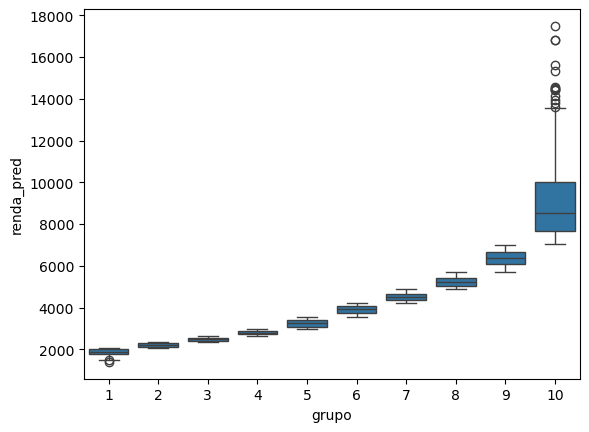

In [40]:
# Dividir as previsões em 10 grupos
df_test = X_test.copy()
df_test["renda_pred"] = np.exp(y_pred_log)
df_test["grupo"] = pd.qcut(df_test["renda_pred"], labels=np.arange(1, 11), q=10)

# Calcular estatísticas por grupo
stats = df_test.groupby("grupo")["renda_pred"].agg(
    media=np.mean, mediana=np.median, p5=lambda x: np.percentile(x, 5), p95=lambda x: np.percentile(x, 95)
)
print(stats)

# Gráfico
sns.boxplot(x="grupo", y="renda_pred", data=df_test)
plt.show()

# Conclusão
    Na minha opinião, o modelo não faz uma previsão muito assertiva, pois não prevê nem 40% dos resultados. Ele pode ser melhorado, e há vários outros testes que podem ser feitos em nosso modelo. Mas fico muito feliz por estar finalizando este primeiro projeto.